In [1]:
import pandas as pd
import http.client
import requests
import json
from pandas.io.json import json_normalize
import time
import datetime as dt

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
from google.cloud import bigquery
project_id = ''
client = bigquery.Client(project=project_id)

In [6]:
newpd = client.query('''
  select nle.name
    ,to_address
    ,date(deployed_at)
    ,min(date(block_timestamp)) as max_date
  from `nansen-query.nft_ethereum.nft_list_enriched` nle
  inner join `nansen-query.nft_ethereum.nft_transfers_all_with_context` taw on nle.project_id = taw.project_id
  inner join `nansen-query.nft_ethereum.nft_balances` nbal on nbal.address = taw.to_address and nbal.project_id = taw.project_id
  where nle.project_id in ('0xbd3531da5cf5857e7cfaa92426877b022e612cf8',
                      '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e',
                      '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d',
                      '0x23581767a106ae21c074b2276d25e5c3e136a68b',
                      '0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b',
                      '0xed5af388653567af2f388e6224dc7c4b3241c544')
and nbal.nft_balance>0
group by nle.name,to_address,date(deployed_at)''').to_dataframe()

In [7]:
newpd.columns =['name','token_id','create_date','max_date']

In [8]:
newpd['create_date'] = pd.to_datetime(newpd['create_date'])

In [9]:
newpd['max_date'] = pd.to_datetime(newpd['max_date'])

In [10]:
newpd['current_date'] = '2022-10-15'

In [11]:
newpd['current_date'] = pd.to_datetime(newpd['current_date'])

In [12]:
newpd['day_diff'] = ( newpd['current_date'] - newpd['max_date']).dt.days

In [13]:
newpd['days_alive'] = ( newpd['current_date'] - newpd['create_date']).dt.days

In [14]:
newpd.head()

,name,token_id,create_date,max_date,current_date,day_diff,days_alive
0,CloneX,0x51ae5a026d6adf7d33f7c215cdd893866020aba2,2021-12-12,2022-04-07,2022-10-15,191,307
1,Bored Ape Yacht Club,0xb6c587a6e052161348f5a5736d398d0b5eb748ce,2021-04-22,2021-12-04,2022-10-15,315,541
2,Bored Ape Yacht Club,0x44b51387773ce3581156d9accb27849a204f31dc,2021-04-22,2021-06-23,2022-10-15,479,541
3,Moonbirds,0x272912651d5c58d8fe9ac6e8cfed84bdf9406e27,2022-04-15,2022-06-12,2022-10-15,125,183
4,Azuki,0x124183252c86e093f78e5994916f044d7549bd1e,2022-01-10,2022-01-15,2022-10-15,273,278


In [15]:
newpd['Percent of Lifetime Owned'] =  newpd['day_diff']/newpd['days_alive']

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

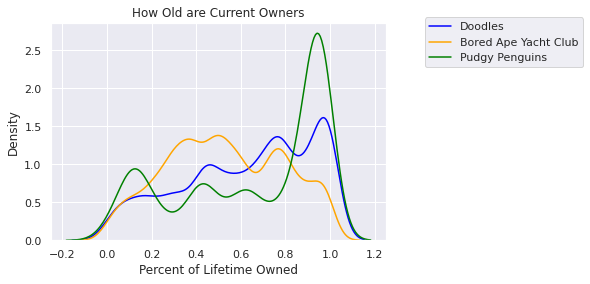

In [19]:
sns.distplot(newpd[newpd['name']=='Doodles']['Percent of Lifetime Owned'], color="blue", label="Doodles",hist=False)
sns.distplot(newpd[newpd['name']=='Bored Ape Yacht Club']['Percent of Lifetime Owned'], color="orange", label="Bored Ape Yacht Club",hist=False)
sns.distplot(newpd[newpd['name']=='Pudgy Penguins']['Percent of Lifetime Owned'], color="green", label="Pudgy Penguins",hist=False)
plt.title('How Old are Current Owners')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()